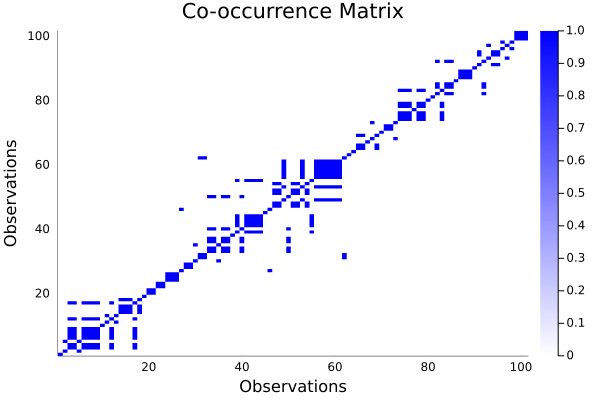

In [3]:
include("../ntl.jl")
import Random

using LinearAlgebra
Random.seed!(1)

data_parameters = Ntl.Models.FiniteTopicModelParameters(num_topics=10, num_words=588, length=10, topic_parameter=0.1, word_parameter=0.1)

psi_prior = Vector{Float64}([1, 1])
phi_prior = Vector{Float64}([1, 1])
geometric_arrival = Ntl.Models.GeometricArrivals(prior=phi_prior, sample_parameter_posterior=true)
ntl_cluster_parameters = Ntl.Models.NtlParameters(psi_prior, geometric_arrival)

topic_mixture_model = Ntl.Models.Mixture(ntl_cluster_parameters, data_parameters)
n = 100
mixture = Ntl.Generate.generate(topic_mixture_model, n=n+1)
data = Matrix(mixture[:, 2:end])
data = Matrix(transpose(data))
training_data = data[:, 1:n]
test_datum = vec(data[:, n+1])
true_clustering = mixture[:, 1]
Ntl.Plot.plot_assignments(true_clustering)
Ntl.Plot.plot_co_occurrence_matrix(true_clustering)

In [10]:
metropolis_hastings_sampler = Ntl.Samplers.MetropolisHastingsSampler(num_iterations=30000, proposal_radius=5, adaptive=true, 
                                                                     assignment_types=["random", "all same cluster", "all different clusters"])
mcmc_output = Ntl.Fitter.fit(training_data, topic_mixture_model, metropolis_hastings_sampler) 

Progress: 100%|█████████████████████████████████████████| Time: 0:15:53
Progress: 100%|█████████████████████████████████████████| Time: 0:14:34
Progress: 100%|█████████████████████████████████████████| Time: 0:14:15


Dict{String, Array} with 3 entries:
  "assignments"       => [1 1 … 1 1; 1 1 … 2 2; … ; 99 99 … 99 99; 99 99 … 99 9…
  "arrival posterior" => [0.196008 0.193731 0.429716; 0.1246 0.189331 0.446649;…
  "log likelihood"    => [-2754.59 -2705.92 -2998.65; -2729.32 -2760.63 -3013.1…

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


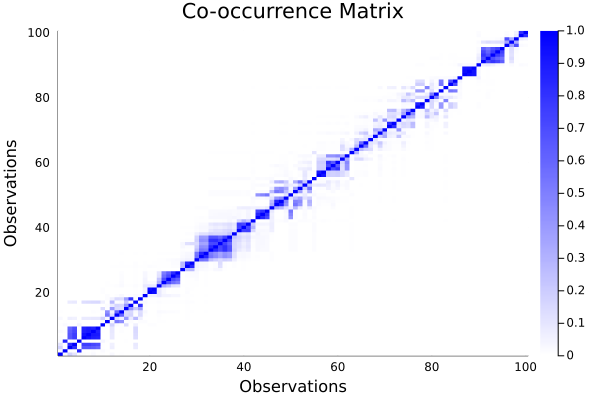

In [11]:
Ntl.Plot.plot_co_occurrence_matrix(mcmc_output["assignments"][:, :, 1])

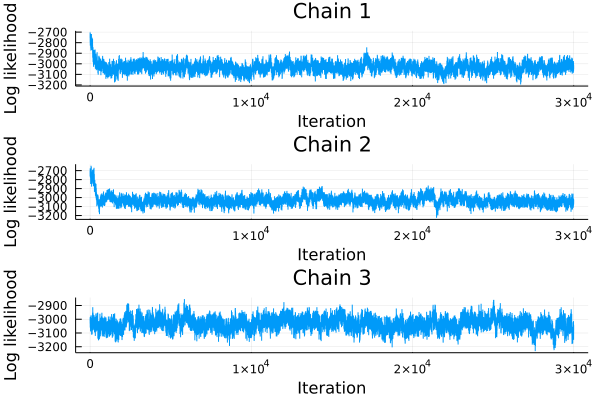

In [12]:
Ntl.Plot.plot_log_likelihoods(mcmc_output["log likelihood"])

In [ ]:
using DataFrames
using CSV
using TextAnalysis

joes_tweets_complete = DataFrame(CSV.File("../data/JoeBidenTweets.csv"))
joes_tweets_complete = joes_tweets_complete[end-99:end, ["timestamp", "tweet"]]
joes_tweets = joes_tweets_complete[:, "tweet"]
joes_tweets = [StringDocument(tweet) for tweet in joes_tweets]

for tweet in joes_tweets
    remove_corrupt_utf8!(tweet)
    remove_case!(tweet)
    prepare!(tweet, strip_articles| strip_indefinite_articles| strip_definite_articles)
    prepare!(tweet, strip_prepositions| strip_pronouns| strip_stopwords| strip_numbers| strip_non_letters)
    prepare!(tweet, strip_html_tags| strip_frequent_terms| strip_sparse_terms)
    stem!(tweet)
end

joes_tweets = [ngrams(tweet) for tweet in joes_tweets]
joes_tweets = [filter(e->!startswith(e.first, "https"), tweet) for tweet in joes_tweets]
joes_tweets = vcat(DataFrame.(joes_tweets)..., cols = :union)
joes_tweets = coalesce.(joes_tweets, 0)
joes_tweets = Matrix(joes_tweets)
joes_tweets = Matrix(transpose(joes_tweets))


588×100 Matrix{Int64}:
 1  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  1  0  1  0  0  0  0  0  0     0  0  0  0  0  1  0  0  0  0  0  1
 2  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0   

Progress: 100%|█████████████████████████████████████████| Time: 0:26:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


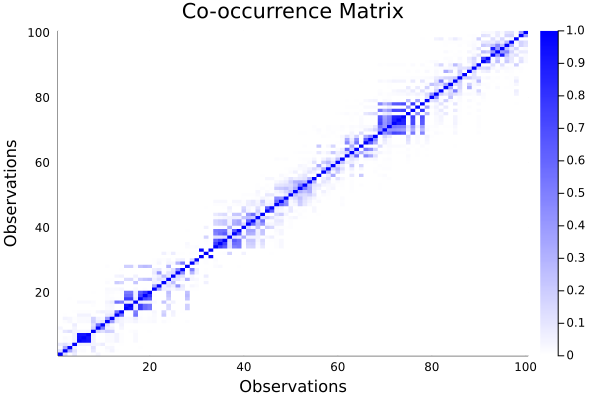

In [ ]:
metropolis_hastings_sampler = Ntl.Samplers.MetropolisHastingsSampler(num_iterations=10000, num_burn_in=40000, proposal_radius=5, skip=20,
                                                                     adaptive=true)
(topic_joe_instances, topic_joe_log_likelihoods) = Ntl.Fitter.fit(joes_tweets, topic_mixture_model, metropolis_hastings_sampler) 
Ntl.Plot.plot_co_occurrence_matrix(topic_joe_instances)

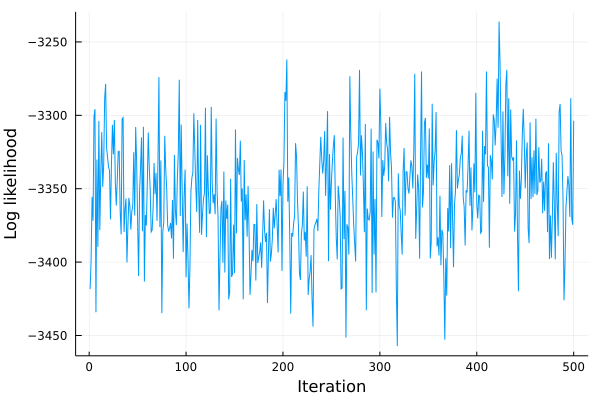

In [ ]:
Ntl.Plot.plot_log_likelihoods(topic_joe_log_likelihoods)

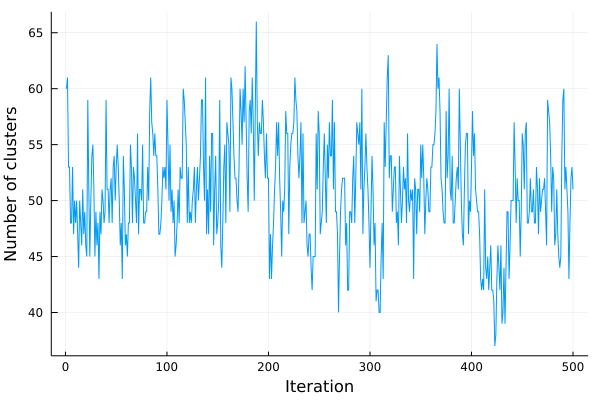

In [ ]:
Ntl.Plot.plot_num_clusters(topic_joe_instances)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: RCall.jl: Loading required package: lpSolve
└ @ RCall /Users/seanla/.julia/packages/RCall/3mHXJ/src/io.jl:160


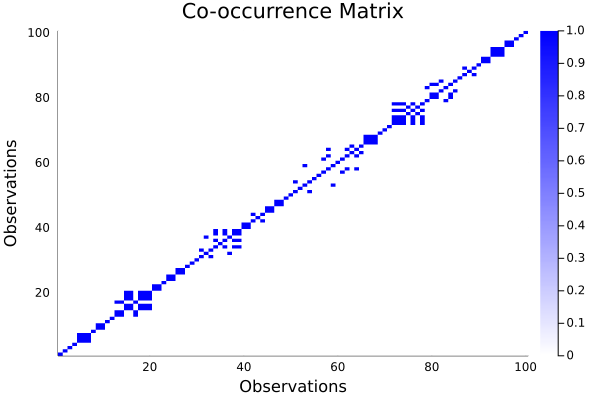

In [ ]:
topic_psm = Ntl.Utils.compute_co_occurrence_matrix(topic_joe_instances)
topic_binder_instance = Ntl.Utils.minbinder(topic_psm, topic_joe_instances)
Ntl.Plot.plot_co_occurrence_matrix(topic_binder_instance)

In [ ]:
joes_tweets_complete[:, "cluster"] = topic_binder_instance 
CSV.write("JoeBidenTweetsClusteringTopic.csv", joes_tweets_complete)

"JoeBidenTweetsClusteringTopic.csv"

Progress: 100%|█████████████████████████████████████████| Time: 0:06:25
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


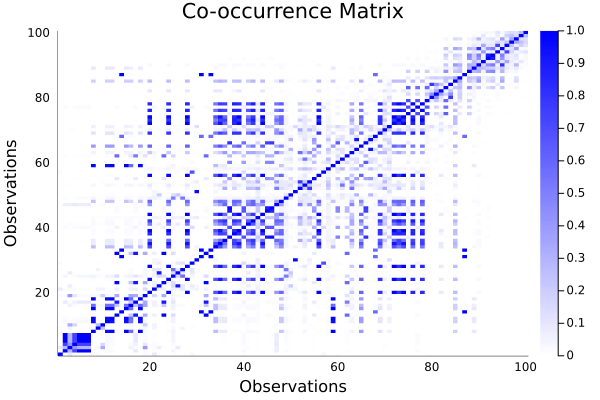

In [ ]:
multinomial_parameters = Ntl.Models.MultinomialParameters(1, (1/10)ones(Int64, size(joes_tweets)[1]))
multinomial_mixture_model = Ntl.Models.Mixture(ntl_cluster_parameters, multinomial_parameters)
metropolis_hastings_sampler = Ntl.Samplers.MetropolisHastingsSampler(num_iterations=10000, num_burn_in=30000, proposal_radius=5, 
                                                                     skip=10, adaptive=true)
(joe_multinomial_instances, joe_multinomial_log_likelihoods) = Ntl.Fitter.fit(joes_tweets, multinomial_mixture_model, metropolis_hastings_sampler) 
Ntl.Plot.plot_co_occurrence_matrix(joe_multinomial_instances)

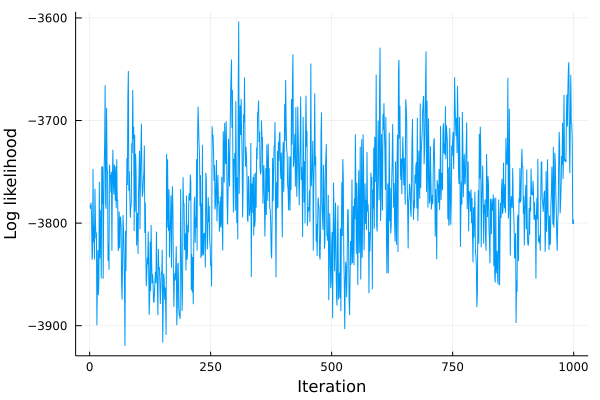

In [ ]:
Ntl.Plot.plot_log_likelihoods(joe_multinomial_log_likelihoods)

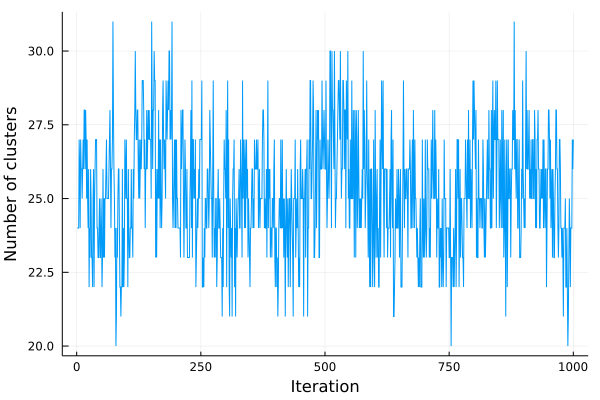

In [ ]:
Ntl.Plot.plot_num_clusters(joe_multinomial_instances)